In [1]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
volmeta = pd.read_csv('Data/updatedvolumemetadata.tsv', sep = '\t')

In [3]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


In [4]:
cleanfiles = [x for x in os.listdir('D:\DH collaborative\OCR\cleannarratives\\')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('D:\DH collaborative\OCR\dirtynarratives\\')
               if x.endswith('.txt')]

In [5]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


In [6]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [7]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


In [8]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 24)

In [9]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [10]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.set_index('chunkid', inplace = True)
cleanmeta.shape

(2489, 24)

In [11]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.set_index('chunkid', inplace = True)
dirtymeta.shape

(2610, 24)

In [12]:
clean_rootdir = 'D:\DH collaborative\OCR\cleannarratives\\'

clean_paths = []

for chunk_id in cleanmeta.index:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')

In [13]:
clean_model_chunk_ids = cleanmeta.index

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1079_1,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1079_10,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1079_11,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1079_12,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dirty_rootdir = 'D:\DH collaborative\OCR\dirtynarratives\\'

dirty_paths = []

for chunk_id in dirtymeta.index:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymeta.index
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,1,0,0,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_1,0,0,0,3,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1079_10,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1079_11,0,0,0,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_12,0,0,0,2,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0


In [15]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [16]:
print(clean_freqs.shape)
clean_freqs.head()

(2489, 17316)


,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000074,0.000000,0.000074,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.0,0.000158,0.0,0.0,0.000079,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000078,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [18]:
print(dirty_freqs.shape)
dirty_freqs.head()

(2610, 20109)


,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.000077,0.0,0.0,0.000309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.000000,0.0,0.0,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.000000,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.000000,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.000000,0.0,0.0,0.000154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.000231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
clean_regr = clean_freqs.join(cleanmeta.rename(columns={"author": "author_meta"})[['author_meta', 'latestcomp']])
clean_regr.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone,author_meta,latestcomp
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000074,0.000000,0.000074,0.0,...,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_1,0.0,0.000158,0.0,0.0,0.000079,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_10,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_11,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_12,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000078,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768


In [20]:
dirty_regr = dirty_freqs.join(dirtymeta.rename(columns={"author": "author_meta"})[['author_meta', 'latestcomp']])
dirty_regr.head()

,00,000,01,10,100,101,102,103,104,105,...,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed,author_meta,latestcomp
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.000077,0.0,0.0,0.000309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_1,0.000000,0.0,0.0,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_10,0.000000,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_11,0.000000,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768
1079_12,0.000000,0.0,0.0,0.000154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Laurence, Sterne",1768


In [21]:
print(cleanmeta['latestcomp'].min())
print(cleanmeta['latestcomp'].max())
print(dirtymeta['latestcomp'].min())
print(dirtymeta['latestcomp'].max())

1615
1926
1615
1926


(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  7.,
         0.,  0.,  0.,  6.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         8., 12.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,
         0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  7.,  0., 15.,  0.,  0.,
         0.,  0.,  0.,  5.,  0.,  0., 10., 27.,  4., 51.,  0., 12.,  0.,
         0.,  4.,  0., 13.,  3.,  0., 11.,  0., 22., 10., 13.,  4.,  0.,
        38.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  8.,  0., 20.,  9.,
         3.,  0.,  0., 12., 11., 13.,  5.,  3.,  0.

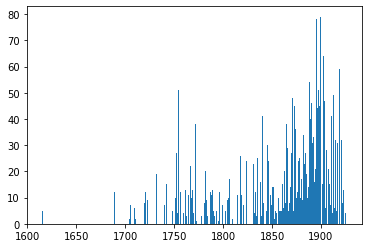

In [22]:
plt.hist(cleanmeta['latestcomp'], range = (1615, 1926), bins = 311)

(array([ 4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  7.,
         0.,  0.,  0., 11.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         7., 13.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 21.,
         0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  8.,  0., 17.,  0.,  0.,
         0.,  0.,  0.,  5.,  0.,  0., 10., 29., 13., 54.,  0., 13.,  0.,
         0.,  4.,  0., 14.,  3.,  0., 12.,  0., 19., 14., 15.,  5.,  0.,
        38.,  1.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  8.,  0., 22., 10.,
         3.,  0.,  0., 13., 12.,  8.,  5.,  3.,  0.

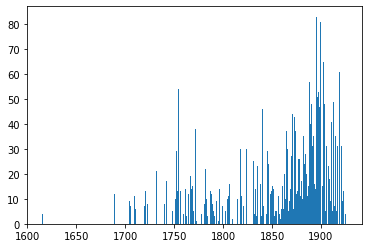

In [23]:
plt.hist(dirtymeta['latestcomp'], range = (1615, 1926), bins = 311)

In [24]:
clean_timeslide = list(range(12))
dirty_timeslide = list(range(12))
for i in range(12):
    timerange = []
    for j in range(1610 + 20*i, 1710 + 20*i):
        timerange.append(j)
    print(timerange)
    clean_timeslide[i] = clean_regr[clean_regr['latestcomp'].isin(timerange)]
    dirty_timeslide[i] = dirty_regr[dirty_regr['latestcomp'].isin(timerange)]
    print(len(clean_timeslide[i]))
    print(len(dirty_timeslide[i]))

[1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709]
32
43
[1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 16

In [25]:
clean_timeslide = list(range(5))
dirty_timeslide = list(range(5))
for i in range(5):
    timerange = []
    for j in range(1750 + 20*i, 1850 + 20*i):
        timerange.append(j)
    print(timerange)
    clean_timeslide[i] = clean_regr[clean_regr['latestcomp'].isin(timerange)]
    dirty_timeslide[i] = dirty_regr[dirty_regr['latestcomp'].isin(timerange)]
    print(len(clean_timeslide[i]))
    print(len(dirty_timeslide[i]))

[1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849]
673
722
[1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 

In [26]:
for i in range(5):
    clean_timeslide[i] = clean_timeslide[i].sample(n = 673)
    dirty_timeslide[i] = dirty_timeslide[i].sample(n = 655)

1750-1849
[[ 8.00469947  9.32322747 10.31324499 10.3293031  10.3294694  10.32947107
  10.32947108 10.32947108 10.32947108 10.32947108]
 [ 7.06984672  6.67898383  6.71831356  6.7187439   6.71874821  6.71874825
   6.71874825  6.71874825  6.71874825  6.71874825]
 [ 6.81095977  6.26675847  6.28294836  6.2831226   6.28312435  6.28312436
   6.28312436  6.28312436  6.28312436  6.28312436]
 [ 6.80666825  6.15661223  6.16435025  6.16443029  6.16443109  6.1644311
   6.1644311   6.1644311   6.1644311   6.1644311 ]
 [ 6.64707358  6.08192003  6.09143172  6.09153158  6.09153258  6.09153259
   6.09153259  6.09153259  6.09153259  6.09153259]
 [ 6.56697429  5.95643992  5.96244156  5.96252811  5.96252897  5.96252898
   5.96252898  5.96252898  5.96252898  5.96252898]
 [ 6.48159528  5.86512355  5.87121058  5.87128745  5.87128822  5.87128823
   5.87128823  5.87128823  5.87128823  5.87128823]
 [ 6.45330371  5.80428934  5.80669785  5.80672374  5.806724    5.80672401
   5.80672401  5.80672401  5.80672401  5.8

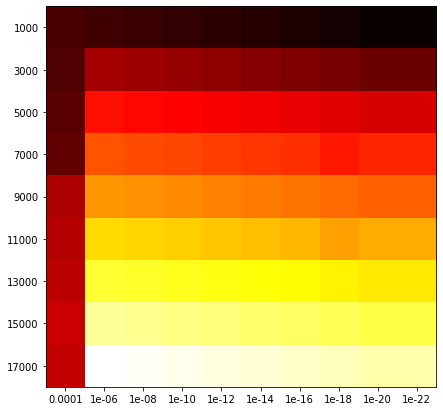

1770-1869
[[ 9.04213933 10.59463367 11.96087124 11.98524955 11.98549483 11.98549728
  11.98549731 11.98549731 11.98549731 11.98549731]
 [ 8.40494188  7.85714459  7.90881095  7.90937488  7.90938052  7.90938058
   7.90938058  7.90938058  7.90938058  7.90938058]
 [ 8.24694214  7.56220369  7.57925735  7.57944485  7.57944672  7.57944674
   7.57944674  7.57944674  7.57944674  7.57944674]
 [ 8.09974711  7.30816967  7.3202527   7.32039848  7.32039994  7.32039995
   7.32039995  7.32039995  7.32039995  7.32039995]
 [ 8.05731195  7.21926301  7.22814676  7.22825216  7.22825321  7.22825322
   7.22825322  7.22825322  7.22825322  7.22825322]
 [ 7.9963367   7.14944975  7.15318454  7.15323882  7.15323937  7.15323937
   7.15323937  7.15323937  7.15323937  7.15323937]
 [ 7.89930063  6.94896688  6.94764834  6.94763817  6.94763807  6.94763807
   6.94763807  6.94763807  6.94763807  6.94763807]
 [ 7.82752685  6.84499883  6.84267397  6.84266779  6.84266773  6.84266773
   6.84266773  6.84266773  6.84266773  6.

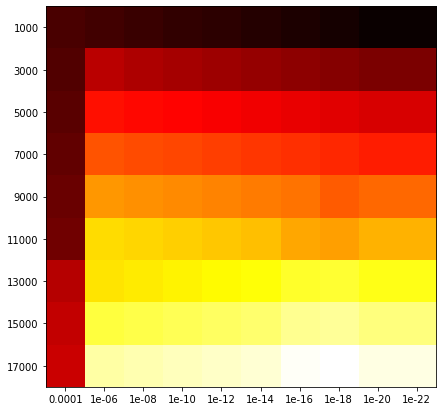

1790-1889
[[11.97025977 14.21631123 16.27275966 16.31246347 16.31286356 16.31286756
  16.3128676  16.3128676  16.3128676  16.3128676 ]
 [10.70011485  9.92801344  9.98229968  9.98291836  9.98292455  9.98292461
   9.98292461  9.98292461  9.98292461  9.98292461]
 [10.30500943  9.51098992  9.52710196  9.52727251  9.52727421  9.52727423
   9.52727423  9.52727423  9.52727423  9.52727423]
 [10.19452506  9.40312149  9.4049912   9.40500967  9.40500986  9.40500986
   9.40500986  9.40500986  9.40500986  9.40500986]
 [ 9.86070614  9.1216658   9.13247166  9.13260718  9.13260853  9.13260854
   9.13260854  9.13260854  9.13260854  9.13260854]
 [ 9.84129503  9.0809296   9.0887817   9.08888723  9.08888829  9.0888883
   9.0888883   9.0888883   9.0888883   9.0888883 ]
 [ 9.81541494  9.13221261  9.14236912  9.14247375  9.1424748   9.14247481
   9.14247481  9.14247481  9.14247481  9.14247481]
 [ 9.60825173  9.00408668  9.01528227  9.0154097   9.01541098  9.015411
   9.015411    9.015411    9.015411    9.015

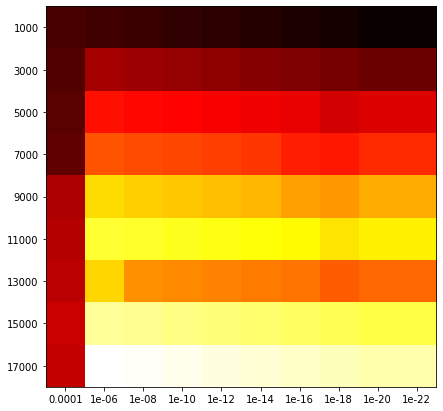

1810-1909
[[13.98177569 15.81047135 17.5744879  17.60627546 17.60659554 17.60659874
  17.60659878 17.60659878 17.60659878 17.60659878]
 [13.27573899 13.14793784 13.21285501 13.21351078 13.21351734 13.2135174
  13.2135174  13.2135174  13.2135174  13.2135174 ]
 [12.5091896  12.27900592 12.31493479 12.31533418 12.31533818 12.31533822
  12.31533822 12.31533822 12.31533822 12.31533822]
 [12.48175011 12.1440755  12.17387137 12.17417972 12.1741828  12.17418283
  12.17418283 12.17418283 12.17418283 12.17418283]
 [12.4196805  11.98552806 12.01190872 12.01218244 12.01218517 12.0121852
  12.0121852  12.0121852  12.0121852  12.0121852 ]
 [12.31197754 11.73925595 11.75864513 11.7588489  11.75885094 11.75885096
  11.75885096 11.75885096 11.75885096 11.75885096]
 [12.29601909 11.75049144 11.77191233 11.77213837 11.77214063 11.77214065
  11.77214065 11.77214065 11.77214065 11.77214065]
 [12.17588238 11.47598199 11.4917429  11.49193622 11.49193815 11.49193817
  11.49193817 11.49193817 11.49193817 11.49

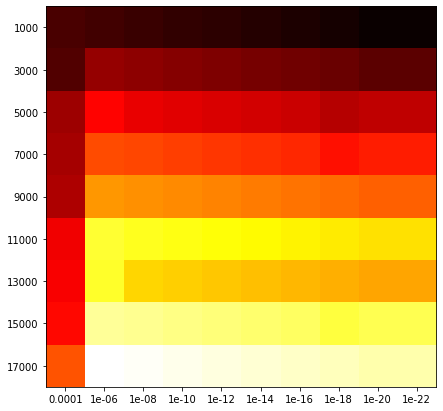

1830-1929
[[12.55024694 13.04797252 14.57145142 14.59906061 14.59933867 14.59934145
  14.59934148 14.59934148 14.59934148 14.59934148]
 [11.8427188  10.93356728 10.98398877 10.98454492 10.98455049 10.98455054
  10.98455054 10.98455054 10.98455054 10.98455054]
 [11.56347921 10.35965295 10.3607991  10.36081408 10.36081423 10.36081423
  10.36081423 10.36081423 10.36081423 10.36081423]
 [11.30086657  9.94890042  9.94443402  9.94439043  9.94439     9.94438999
   9.94438999  9.94438999  9.94438999  9.94438999]
 [11.22364914  9.69684422  9.68069133  9.68053874  9.68053722  9.6805372
   9.6805372   9.6805372   9.6805372   9.6805372 ]
 [11.15149659  9.63402556  9.61536599  9.6151768   9.61517491  9.61517489
   9.61517489  9.61517489  9.61517489  9.61517489]
 [11.16320438  9.74155229  9.7270079   9.7268609   9.72685943  9.72685942
   9.72685942  9.72685942  9.72685942  9.72685942]
 [11.0248929   9.60785054  9.59383764  9.59369676  9.59369536  9.59369534
   9.59369534  9.59369534  9.59369534  9.5

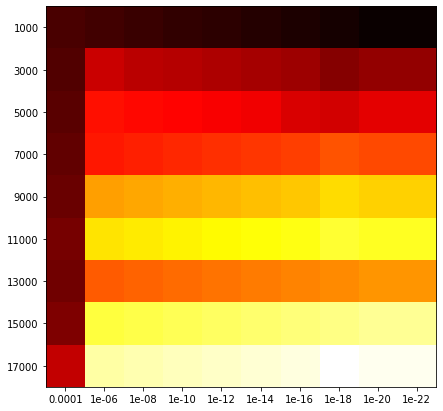

In [27]:
alphaoptions = [1e-04, 1e-06, 1e-08, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20, 1e-22]
featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000]
clean_keys_list = pd.Series()
clean_diffs_list = pd.Series()

for i in range(5):
    resultarray = []
    print(1750 + 20*i, '-', 1850 + 20*i - 1, sep = '')
    clean_features = clean_timeslide[i].drop(['latestcomp', 'author_meta'], axis = 1)
    clean_keys = clean_timeslide[i]['latestcomp']
    for featurecount in featureoptions:
        docfreqs = []
        for col in clean_features.columns:
            docfreqs.append((sum(clean_features[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending 
        model_features = clean_features.loc[ : , features]
    
        resultrow = []
    
        for alpha_param in alphaoptions:
            clf = Ridge(alpha = alpha_param, random_state = 42)
            group_kfold = GroupKFold(n_splits=10)
            mean_score = 0
            for train_index, test_index in group_kfold.split(model_features, clean_keys, groups = clean_timeslide[i]['author']):
                X_train = model_features.iloc[train_index, :]
                X_test = model_features.iloc[test_index, :]
                y_train = clean_keys.iloc[train_index]
                y_test = clean_keys.iloc[test_index]
                clf.fit(X_train, y_train)
                clean_preds = clf.predict(X_test)
                clean_diffs = clean_preds - y_test
                clean_absolute_diffs = np.abs(clean_diffs)
                fold_mean = clean_absolute_diffs.mean()
                mean_score += fold_mean
            mean_score = mean_score/10
            resultrow.append(mean_score)
    
        resultarray.append(resultrow)
        
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    minerror = np.where(resarray == np.amin(resarray))
    best_feature_num = featureoptions[minerror[0][0]]
    best_alpha = alphaoptions[minerror[1][0]]
    print(resultarray)
    print(best_feature_num, best_alpha, np.amin(resultarray))

    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in alphaoptions]
    plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
    plt.show()
    
    docfreqs = []
    for col in clean_features.columns:
        docfreqs.append((sum(clean_features[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-best_feature_num: ]]  # because sorted ascending 
    model_features = clean_features.loc[ : , features]

    clf = Ridge(alpha = best_alpha)
    clean_preds = cross_val_predict(clf, model_features, clean_keys, cv = 10) 
    clean_diffs = clean_preds - clean_keys
    clean_keys_list = pd.concat([clean_keys_list, clean_keys])
    clean_diffs_list = pd.concat([clean_diffs_list, clean_diffs])

In [28]:
clean_absolute_diffs = np.abs(clean_diffs_list)
print(clean_diffs_list.mean())
print(clean_absolute_diffs.mean())

-0.18241070505075077
7.450818607162885


1750-1849
[[7.05408759 7.37389826 7.93202866 7.94113462 7.94122649 7.94122741
  7.94122741 7.94122741 7.94122741 7.94122741]
 [6.07700574 5.27471693 5.28970045 5.28987642 5.28987818 5.2898782
  5.2898782  5.2898782  5.2898782  5.2898782 ]
 [5.85398152 4.96201662 4.96370104 4.9637268  4.96372706 4.96372706
  4.96372706 4.96372706 4.96372706 4.96372706]
 [5.82993391 4.93056946 4.92702476 4.926999   4.92699874 4.92699874
  4.92699874 4.92699874 4.92699874 4.92699874]
 [5.70508741 4.84887574 4.84731923 4.84730912 4.84730902 4.84730902
  4.84730902 4.84730902 4.84730902 4.84730902]
 [5.63064201 4.74269713 4.73879991 4.73876131 4.73876093 4.73876092
  4.73876092 4.73876092 4.73876092 4.73876092]
 [5.58100245 4.70580019 4.70072082 4.70067112 4.70067063 4.70067062
  4.70067062 4.70067062 4.70067062 4.70067062]
 [5.57606024 4.70803491 4.7029148  4.70286397 4.70286346 4.70286345
  4.70286345 4.70286345 4.70286345 4.70286345]
 [5.56184923 4.71234176 4.7079139  4.70787542 4.70787503 4.70787503
  4

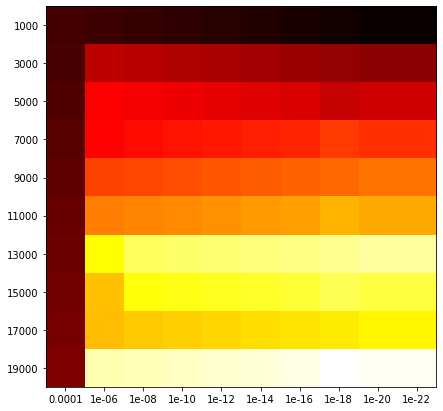

1770-1869
[[8.91761137 9.40335721 9.7879989  9.79334967 9.7934032  9.79340373
  9.79340374 9.79340374 9.79340374 9.79340374]
 [8.24837724 7.60803752 7.65429228 7.6548065  7.65481165 7.6548117
  7.6548117  7.6548117  7.6548117  7.6548117 ]
 [8.01978238 7.33837292 7.35786869 7.35808968 7.3580919  7.35809192
  7.35809192 7.35809192 7.35809192 7.35809192]
 [7.74640945 6.94793079 6.95480184 6.95488277 6.95488358 6.95488359
  6.95488359 6.95488359 6.95488359 6.95488359]
 [7.60599187 6.66521413 6.65623023 6.65614101 6.65614012 6.65614011
  6.65614011 6.65614011 6.65614011 6.65614011]
 [7.48124237 6.51307486 6.50521753 6.50515324 6.5051526  6.50515259
  6.50515259 6.50515259 6.50515259 6.50515259]
 [7.44061451 6.54121012 6.53353692 6.53346469 6.53346397 6.53346396
  6.53346396 6.53346396 6.53346396 6.53346396]
 [7.40909546 6.50727815 6.49743062 6.49733233 6.49733135 6.49733134
  6.49733134 6.49733134 6.49733134 6.49733134]
 [7.40909952 6.54980469 6.54140753 6.54132586 6.54132504 6.54132503
  6

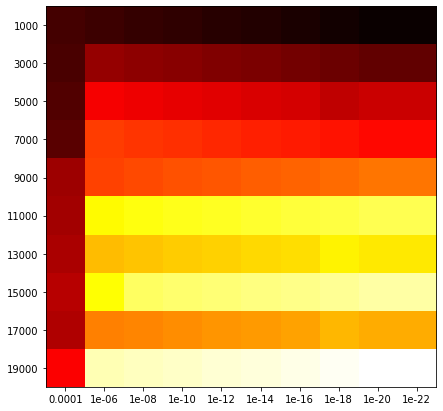

1790-1889
[[12.17572552 12.5004518  13.77513874 13.79697151 13.79719099 13.79719318
  13.79719321 13.79719321 13.79719321 13.79719321]
 [11.41134273  9.70951434  9.69133636  9.69118386  9.69118233  9.69118231
   9.69118231  9.69118231  9.69118231  9.69118231]
 [10.96844974  9.26615865  9.25469244  9.25457918  9.25457805  9.25457804
   9.25457804  9.25457804  9.25457804  9.25457804]
 [10.81582304  9.14643651  9.13016512  9.13002925  9.13002789  9.13002788
   9.13002788  9.13002788  9.13002788  9.13002788]
 [10.51232381  9.00393234  8.98989833  8.98975787  8.98975647  8.98975646
   8.98975646  8.98975646  8.98975646  8.98975646]
 [10.41503863  8.93687716  8.92020593  8.92003833  8.92003666  8.92003664
   8.92003664  8.92003664  8.92003664  8.92003664]
 [10.18478161  8.67395687  8.65604369  8.65586921  8.65586747  8.65586745
   8.65586745  8.65586745  8.65586745  8.65586745]
 [10.1436388   8.65035845  8.63227286  8.63209034  8.63208851  8.63208849
   8.63208849  8.63208849  8.63208849  8.

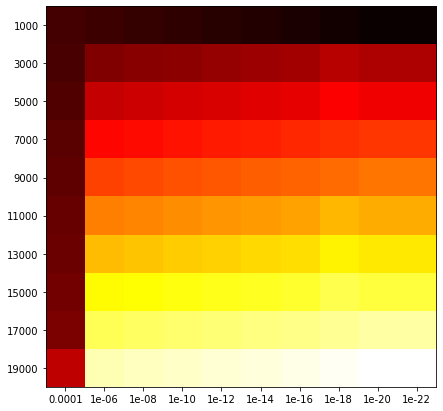

1810-1909
[[12.09847484 13.34792186 14.69243449 14.71259697 14.71279949 14.71280152
  14.71280154 14.71280154 14.71280154 14.71280154]
 [11.52203273 10.61443633 10.65558506 10.65605308 10.65605776 10.65605781
  10.65605781 10.65605781 10.65605781 10.65605781]
 [10.96697759 10.20240398 10.21749441 10.21767001 10.21767176 10.21767178
  10.21767178 10.21767178 10.21767178 10.21767178]
 [10.86763843  9.9320794   9.94251365  9.94262984  9.942631    9.94263101
   9.94263101  9.94263101  9.94263101  9.94263101]
 [10.74521897  9.67023382  9.67494836  9.67500829  9.67500889  9.67500889
   9.67500889  9.67500889  9.67500889  9.67500889]
 [10.6644199   9.56966686  9.56872648  9.56871857  9.5687185   9.56871849
   9.56871849  9.56871849  9.56871849  9.56871849]
 [10.56423971  9.45324214  9.4515218   9.45150898  9.45150885  9.45150885
   9.45150885  9.45150885  9.45150885  9.45150885]
 [10.48553961  9.41594064  9.41366824  9.41364648  9.41364626  9.41364626
   9.41364626  9.41364626  9.41364626  9.

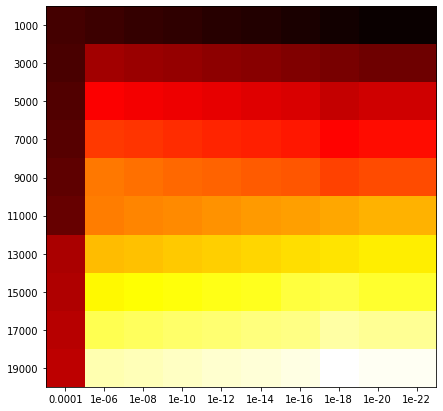

1830-1929
[[11.98176734 15.35708144 17.03925234 17.06499936 17.06525796 17.06526054
  17.06526057 17.06526057 17.06526057 17.06526057]
 [11.33519102 11.25703562 11.32998657 11.33080197 11.33081013 11.33081021
  11.33081021 11.33081021 11.33081021 11.33081021]
 [11.13756021 10.85135437 10.88912819 10.88952047 10.88952439 10.88952443
  10.88952443 10.88952443 10.88952443 10.88952443]
 [11.07783455 10.46998696 10.47791544 10.47804603 10.47804734 10.47804735
  10.47804735 10.47804735 10.47804735 10.47804735]
 [10.92105752 10.11747948 10.11255773 10.11252634 10.11252602 10.11252602
  10.11252602 10.11252602 10.11252602 10.11252602]
 [10.85305894  9.93305098  9.91995165  9.91982867  9.91982744  9.91982743
   9.91982743  9.91982743  9.91982743  9.91982743]
 [10.87408823  9.98268508  9.97097963  9.97086688  9.97086575  9.97086574
   9.97086574  9.97086574  9.97086574  9.97086574]
 [10.78849115  9.95434364  9.94414728  9.94405557  9.94405465  9.94405464
   9.94405464  9.94405464  9.94405464  9.

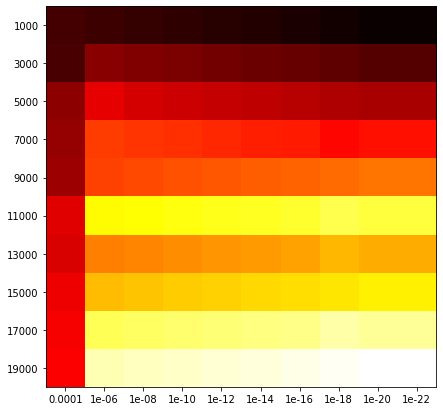

In [29]:
featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000]
alphaoptions = [1e-04, 1e-06, 1e-08, 1e-10, 1e-12, 1e-14, 1e-16, 1e-18, 1e-20, 1e-22]

dirty_keys_list = pd.Series()
dirty_diffs_list = pd.Series()

for i in range(5):
    resultarray = []
    print(1750 + 20*i, '-', 1850 + 20*i - 1, sep = '')
    dirty_features = dirty_timeslide[i].drop(['latestcomp', 'author_meta'], axis = 1)
    dirty_keys = dirty_timeslide[i]['latestcomp']
    for featurecount in featureoptions:
        docfreqs = []
        for col in dirty_features.columns:
            docfreqs.append((sum(dirty_features[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount: ]]  # because sorted ascending 
        model_features = dirty_features.loc[ : , features]
    
        resultrow = []
    
        for alpha_param in alphaoptions:
            clf = Ridge(alpha = alpha_param, random_state = 42)
            group_kfold = GroupKFold(n_splits=10)
            mean_score = 0
            for train_index, test_index in group_kfold.split(model_features, dirty_keys, groups = dirty_timeslide[i]['author']):
                X_train = model_features.iloc[train_index, :]
                X_test = model_features.iloc[test_index, :]
                y_train = dirty_keys.iloc[train_index]
                y_test = dirty_keys.iloc[test_index]
                clf.fit(X_train, y_train)
                dirty_preds = clf.predict(X_test)
                dirty_diffs = dirty_preds - y_test
                dirty_absolute_diffs = np.abs(dirty_diffs)
                fold_mean = dirty_absolute_diffs.mean()
                mean_score += fold_mean
            mean_score = mean_score/10
            resultrow.append(mean_score)
    
        resultarray.append(resultrow)
        
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    minerror = np.where(resarray == np.amin(resarray))
    best_feature_num = featureoptions[minerror[0][0]]
    best_alpha = alphaoptions[minerror[1][0]]
    print(resultarray)
    print(best_feature_num, best_alpha, np.amin(resultarray))

    fig, ax = plt.subplots(figsize=(7,7))
    ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in alphaoptions]
    plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
    plt.show()
    
    docfreqs = []
    for col in dirty_features.columns:
        docfreqs.append((sum(dirty_features[col] > 0), col))
    docfreqs.sort()
    features = [x[1] for x in docfreqs[-best_feature_num: ]]  # because sorted ascending 
    model_features = dirty_features.loc[ : , features]

    clf = Ridge(alpha = best_alpha)
    dirty_preds = cross_val_predict(clf, model_features, dirty_keys, cv = 10) 
    dirty_diffs = dirty_preds - dirty_keys
    dirty_keys_list = pd.concat([dirty_keys_list, dirty_keys])
    dirty_diffs_list = pd.concat([dirty_diffs_list, dirty_diffs])

In [30]:
dirty_absolute_diffs = np.abs(dirty_diffs_list)
print(dirty_diffs_list.mean())
print(dirty_absolute_diffs.mean())

-0.09406853238738534
7.20266839210504


In [31]:
frame = { 'year': clean_keys_list, 'diffs': clean_diffs_list, 'abs_diffs': clean_absolute_diffs}
clean_result = pd.DataFrame(frame)
clean_result['index'] = clean_result.index
clean_result = clean_result.sort_values('index')
print(clean_result.shape)
clean_result.head()

(3365, 4)


,year,diffs,abs_diffs,index
1079_0,1768,14.855007,14.855007,1079_0
1079_1,1768,10.868981,10.868981,1079_1
1079_10,1768,11.064323,11.064323,1079_10
1079_11,1768,-10.281902,10.281902,1079_11
1079_12,1768,-2.729930,2.729930,1079_12


In [32]:
clean_year = clean_result.groupby('index')['year'].mean()
clean_diff = clean_result.groupby('index')['diffs'].mean()
clean_abs_diff = clean_result.groupby('index')['abs_diffs'].mean()
clean_grouped_result = pd.DataFrame({'year':clean_year, 'diffs': clean_diff, 'abs_diffs': clean_abs_diff })
print(clean_grouped_result.shape)
clean_grouped_result.head()

(1848, 3)


,year,diffs,abs_diffs
index,,,
1079_0,1768,14.855007,14.855007
1079_1,1768,10.868981,10.868981
1079_10,1768,11.064323,11.064323
1079_11,1768,-10.281902,10.281902
1079_12,1768,-2.729930,2.729930


In [33]:
frame = { 'year': dirty_keys_list, 'diffs': dirty_diffs_list, 'abs_diffs': dirty_absolute_diffs}
dirty_result = pd.DataFrame(frame)
dirty_result['index'] = dirty_result.index
dirty_result = dirty_result.sort_values('index')
print(dirty_result.shape)
dirty_result.head()

(3275, 4)


,year,diffs,abs_diffs,index
1079_0,1768,0.857910,0.857910,1079_0
1079_1,1768,-0.443055,0.443055,1079_1
1079_10,1768,1.294404,1.294404,1079_10
1079_11,1768,1.726981,1.726981,1079_11
1079_13,1768,0.878939,0.878939,1079_13


In [34]:
dirty_year = dirty_result.groupby('index')['year'].mean()
dirty_diff = dirty_result.groupby('index')['diffs'].mean()
dirty_abs_diff = dirty_result.groupby('index')['abs_diffs'].mean()
dirty_grouped_result = pd.DataFrame({'year':dirty_year, 'diffs': dirty_diff, 'abs_diffs': dirty_abs_diff })
print(dirty_grouped_result.shape)
dirty_grouped_result.head()

(1829, 3)


,year,diffs,abs_diffs
index,,,
1079_0,1768,0.857910,0.857910
1079_1,1768,-0.443055,0.443055
1079_10,1768,1.294404,1.294404
1079_11,1768,1.726981,1.726981
1079_13,1768,0.878939,0.878939


Text(0.5, 1.0, 'Dirty text + absolute diffs')

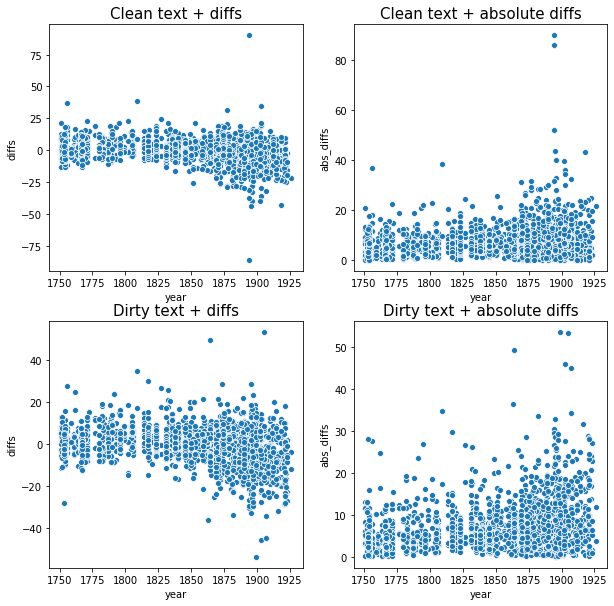

In [35]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize = (10, 10))
sns.scatterplot(clean_grouped_result['year'], clean_grouped_result['diffs'], ax = axs[0, 0])
axs[0, 0].set_title('Clean text + diffs', fontsize= 15)
sns.scatterplot(clean_grouped_result['year'], clean_grouped_result['abs_diffs'], ax = axs[0, 1])
axs[0, 1].set_title('Clean text + absolute diffs', fontsize= 15)
sns.scatterplot(dirty_grouped_result['year'], dirty_grouped_result['diffs'], ax = axs[1, 0])
axs[1, 0].set_title('Dirty text + diffs', fontsize= 15)
sns.scatterplot(dirty_grouped_result['year'], dirty_grouped_result['abs_diffs'], ax = axs[1, 1])
axs[1, 1].set_title('Dirty text + absolute diffs', fontsize= 15)

In [36]:
import scipy.stats as stats
print(stats.pearsonr(clean_result["year"], clean_result["diffs"]))
print(stats.pearsonr(clean_result["year"], clean_result["abs_diffs"]))
print(stats.pearsonr(dirty_result["year"], dirty_result["diffs"]))
print(stats.pearsonr(dirty_result["year"], dirty_result["abs_diffs"]))

(-0.2500902188981823, 3.741883901453653e-49)
(0.11454071089325749, 2.6679771600984286e-11)
(-0.2401738963392155, 3.4262885510702155e-44)
(0.1578280714820513, 1.0305748632836813e-19)


In [40]:
print(clean_result.mean())
print(clean_grouped_result.mean())
print(dirty_result.mean())
print(dirty_grouped_result.mean())

year         1850.160178
diffs          -0.182411
abs_diffs       7.450819
dtype: float64
year         1854.797619
diffs          -1.108870
abs_diffs       7.651678
dtype: float64
year         1849.393282
diffs          -0.094069
abs_diffs       7.202668
dtype: float64
year         1853.534718
diffs          -1.015335
abs_diffs       7.294987
dtype: float64


<h3>Summary</h3>
The results of publication date prediction with data of different periods (100 years range, with 20 years step, between 1750 to 1930) show that:<br>
(1) The sheer amount of difference in predicting years is negatively correlated with the year of publication (the model tends to predict the publication date to an earlier date for the later books), while the amount of difference between predictions (the absolute value of difference) is positively correlated to with the year of publication (the model does a better job in predicting books of an earlier publication date).<br>
(2) The results in (1) hold true for both dirty and clean chunks, and both correlations are very significant. But the dirty chunks show a stronger (and more significant) result in terms of the absolute value of difference, while the clean chunks shows a stronger (and more significant) result in terms of the sheer amount of difference.<br>
(3) The result in the previous experiment (publication year prediction with all data) that the dirty texts predict the publicaton year more accurately than the clean texts holds true (absolute difference: 7.29 vs 7.65, compared with the previous experiment: 15.83 vs 17.29. The difference is explainable as we are predicting the data in a much narrower range of 100 years). However, the result that the dirty texts tend to predict the texts to an earlier date than the clean texts no longer holds true (sheer difference: -1.01 vs -1.11, compared with the previous experiment: 0.51 vs 0.95). Actually, in the previous experiment, the sheer amount difference is positive (the model tends to predict the publication date to an later date). But in this experiment, the sheer amount difference is negative (the model tends to predict the publication date to an earlier date),<br>
(4) The results in grid search could also be interesting: the optimized value is always achieved when the number of features are maximized (there could be overfitting here, due to the limited number of cases in the experiment). However, the alpha value is pretty different for the model predicting clean chunks (some are optimized when alpha = 1e-06, others are optimized when alpha = 1e-18). I am not sure about the reason yet.